# Asset Pricing Homework 3

*By Daniel Deutsch, José Lucas Barretto and Ziyad Bekkaoui*.

In [37]:
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
from statsmodels.tsa import stattools as smt
from statsmodels.formula import api as smf

In [38]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Importing Datasets

Firstly, we load the data into dataframes. 

For this homework we decided to work with ___'s stock data because ______. As one can verify below, we chose to work with a **monthly frequency between the years 2000 and 2020** due to ______.

We obtain the data from two different sources.

- Sony's Candles and dividends: [Yahoo Finance](https://finance.yahoo.com/);
- Risk Free Rate: [https://fred.stlouisfed.org/series/IRLTLT01USM156N?fbclid=IwAR06pLCiBhQBF8GcMPFIm1sOkVlO_ZkytrM2OerSlLjjDsyAymV26azJYeQ](https://fred.stlouisfed.org/series/IRLTLT01USM156N?fbclid=IwAR06pLCiBhQBF8GcMPFIm1sOkVlO_ZkytrM2OerSlLjjDsyAymV26azJYeQ)

Once the data is loaded, we can apply the log-transform to our time series.

In [39]:
# Defines the stock
stock = yf.Ticker('MCD')

# Obtains the OHLCV dataframe
df_candles = stock.history(start='2000-01-02', end='2020-12-31').reset_index()
df_candles['Date'] = df_candles['Date'].astype('datetime64[M]')
df_candles.drop_duplicates(subset='Date', keep='last', inplace=True, ignore_index=True)
df_candles = df_candles[['Date', 'Close']]
df_candles.rename(columns={'Date': 'date', 'Close': 'close'}, inplace=True)

# Obtains the dividends dataframe
df_dividends = stock.dividends.to_frame().reset_index()
df_dividends.rename(columns={'Date': 'date', 'Dividends': 'dividend'}, inplace=True)
df_dividends['date'] = df_dividends['date'].astype('datetime64[M]')

# Obtains the risk free rate dataframe
df_rf = pd.read_csv("./datasets/risk_free_rate.csv", parse_dates=['date'], names=['date', 'rf'], skiprows=1).sort_values('date', ignore_index=True)

# Adds only used values to the dataframe
df = pd.merge(df_candles[['date', 'close']], df_dividends, on='date', how='left')
df = df.merge(df_rf, on='date', how='left')
df.set_index('date', inplace=True)

# Bfills dividend data
df['dividend'] = df['dividend'].bfill()

# Applies log-transform to the price and dividends
df['log_close'] = np.log(df['close'])
df['log_dividend'] = np.log(df['dividend'])

# Sets risk free rate to percentage value
df['rf'] /= 100

# Remove Non Available Numbers
df.dropna(inplace=True)

# Deletes unused dataframes to clear memory
del df_dividends, df_candles, df_rf

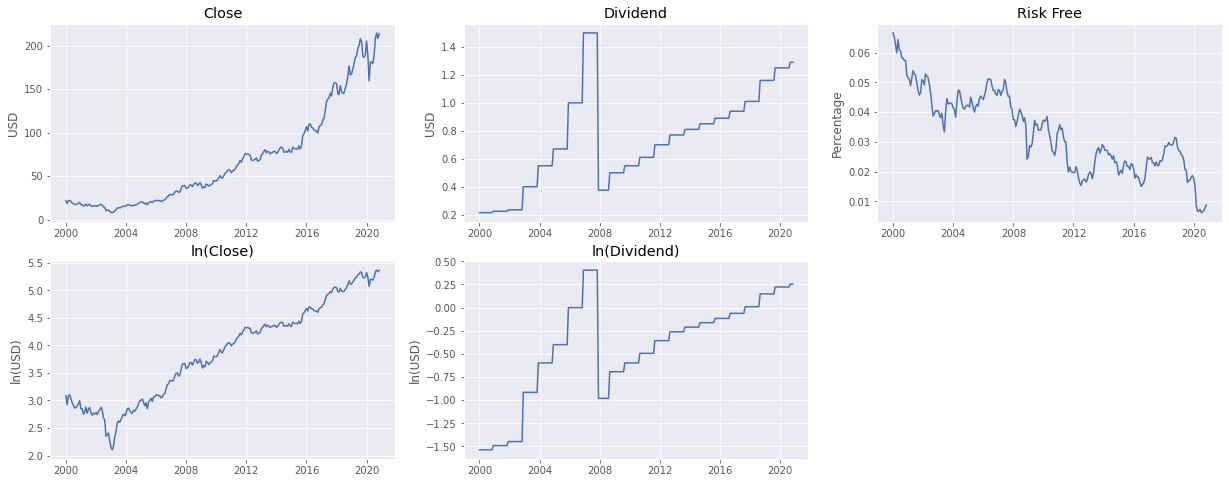

In [40]:
# Plots
fig, axs = plt.subplots(2, 3, figsize=(21, 8))
axs[0, 0].plot(df['close'])
axs[0, 0].set_title("Close")
axs[0, 0].set_ylabel("USD")
axs[1, 0].plot(df['log_close'])
axs[1, 0].set_title("ln(Close)")
axs[1, 0].set_ylabel("ln(USD)")
axs[0, 1].plot(df['dividend'])
axs[0, 1].set_title("Dividend")
axs[0, 1].set_ylabel("USD")
axs[1, 1].plot(df['log_dividend'])
axs[1, 1].set_title("ln(Dividend)")
axs[1, 1].set_ylabel("ln(USD)")
axs[0, 2].plot(df['rf'])
axs[0, 2].set_title("Risk Free")
axs[0, 2].set_ylabel("Percentage")
axs[1, 2].set_visible(False)
plt.show()

# Checking $I(1)$

Firstly we need to verify if our time series are integrated of order 1 I(1). To do so, we use the Augmented Dickey-Fuller Test in the first difference of the considered time series.

The Augmented Dickey-Fuller test is a unit root test that checks for stationarity. It considers the following hypotesis:

$
\begin{aligned}
    H_0: & \quad \text{there is a unit root (the series contains a stochastic trend and is non-stationary)} \\
    H_1: & \quad \text{there isn't a unit root (the series doesn't contain a stochastic trend and is stationary)}
\end{aligned}
$

Once the Augmented Dickey-Fuller Test is performed and we have obtained our results, we should consider the following to take our conclusions:

- If the p-value is lower than 0.05, than we must reject the null hypotesys (and, consequently, accept the alternativel one).
- If the p-value is slightly above 0.05, then the critical values should be used to judge whether to reject the null hypotesis.

We implement the augmented Dickey-Fuller Test to the most general regression:

$
\begin{aligned}
    \Delta X_t = b_0 + b_1 t + \rho X_{t-1} + \sum^{p-1}_{j=1} \varphi_j \Delta_{t-j} + \varepsilon_t 
\end{aligned}
$

In this case, the hypotesis can be written as:

$
\begin{aligned}
    H_0: & \quad \rho = 0 \\
    H_1: & \quad \rho < 0
\end{aligned}
$

In [41]:
# Obtains the first difference
df['log_close_diff'] = df['log_close'].diff()

# Obtains the ADF results for the regression
adf_res = smt.adfuller(
    df['log_close_diff'].dropna(), 
    regression='ct',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Print results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")

T-statistic: -15.101476985339147
P-value: 1.9564174894227455e-22


From the results printed above, we can conclude that **the null hypotesis should be rejected**, thus, the log-transformed closing price time series is I(1).

In [42]:
# Obtains the first difference
df['log_dividend_diff'] = df['log_dividend'].diff()

# Obtains the ADF results for the regression
adf_res = smt.adfuller(
    df['log_dividend_diff'].dropna(), 
    regression='ct',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Print results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")

T-statistic: -15.7679691665026
P-value: 1.2070453349088363e-22


From the results printed above, we can conclude that **the null hypotesis should be rejected**, thus, the log-transformed dividend time series is I(1).

# Gordon-Shapiro Model

## Cointegration Test

Two $I(1)$ processes are said to be cointegrated if there exists a linear combination of their series that is $I(0)$ (without unit-root). If both processes share a common stochastic trend, such as a (weak) random walk, this criterion is satisfied. If the rate return is constant, the price and dividend processes should be cointegrated because:

$
\begin{align*}
    P_t - \frac{D_t}{r} \quad & = \quad \frac{1}{r(1+r)} \sum_{i=0}^{\infty} \frac{1}{(1+r)i} E_t (D_{t+1+i} - D_{t+i})
\end{align*}
$

In practice, $r$ is not known. Thus, one can implement the regression of $P$ on $D$:

$
\begin{align*}
    P_t \quad & = \quad \alpha D_t + u_t
\end{align*}
$

and check that the residual $u_t$ is $I(0)$.

In [43]:
# Obtains the cointegration test results
coint_res = smt.coint(df['close'], df['dividend'])

# Print results
print(f"T-statistic: {coint_res[0]}")
print(f"P-value: {coint_res[1]}")

T-statistic: -1.2807284671419388
P-value: 0.8354754128534516


## Long-Term Equation

To Obtain the long-term equation, we need to add dummy variables representing possible abrupt changes due to, for instance, economical booms and crises. Therefore, we added 3 dummy variables: 

- DUMMY2001: representing the recession in part due to the dot-com speculative bubble;
- Dummy2007: representing the global financial crisis;
- Dummy2020: representing the economical crisis that came with the COVID pandemic;

Once we have our dummy variables, we can fit our data into an OLS regression that will give us the coefficients of the long-term equation.

In [44]:
df['DUMMY2001'] = (df.index >= datetime.fromisoformat('2001-03-31')).astype(int)
df['DUMMY2007'] = (df.index >= datetime.fromisoformat('2007-11-30')).astype(int)
df['DUMMY2020'] = (df.index >= datetime.fromisoformat('2020-02-29')).astype(int)

df

,close,dividend,rf,log_close,log_dividend,log_close_diff,log_dividend_diff,DUMMY2001,DUMMY2007,DUMMY2020
date,,,,,,,,,,
2000-01-01,21.869631,0.215,0.0666,3.085099,-1.537117,NaN,NaN,0,0,0
2000-02-01,18.578218,0.215,0.0652,2.921990,-1.537117,-0.163109,0.000000,0,0,0
2000-03-01,21.869631,0.215,0.0626,3.085099,-1.537117,0.163109,0.000000,0,0,0
2000-04-01,22.271927,0.215,0.0599,3.103327,-1.537117,0.018228,0.000000,0,0,0
2000-05-01,20.955355,0.215,0.0644,3.042394,-1.537117,-0.060933,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2020-07-01,188.751602,1.250,0.0062,5.240432,0.223144,0.051814,0.000000,1,1,1
2020-08-01,208.657761,1.250,0.0065,5.340695,0.223144,0.100264,0.000000,1,1,1
2020-09-01,214.491806,1.290,0.0068,5.368272,0.254642,0.027576,0.031499,1,1,1


In [46]:
# Creates and obtains the results of the OLS model
model = smf.ols('log_close ~ DUMMY2001 + DUMMY2007 + DUMMY2020 + log_dividend + rf', data=df)
model_fit = model.fit()

# Print the long-term equation with all parameters (significant and non-significant)
params = model_fit.params
print(f"Long-term equation: ln(close) = {params[0]:.5f} + {params[1]:.5f}*DUMMY2001 + {params[2]:.5f}*DUMMY2007 + {params[3]:.5f}*DUMMY2020 + {params[4]:.5f}*ln(dividend) + {params[5]:.5f}*rf\n")

# Print the long-term equation only with significant parameters
lte = "Statistically significant long-term equation: ln(close) = "
for coeff, p_value, name in zip(model_fit.params, model_fit.pvalues, ['', 'DUMMY2001', 'DUMMY2007', 'DUMMY2020', 'ln(dividend)', 'rf']):
    if p_value <= 0.05:
        lte += f"+ {coeff:.5f}*{name} " if name else f"{coeff:.5f} "
print(f"{lte}\n")

# Print the summary
print(model_fit.summary())

Long-term equation: ln(close) = 4.53990 + -0.80633*DUMMY2001 + 1.09623*DUMMY2007 + 0.32889*DUMMY2020 + 0.70142*ln(dividend) + -9.05731*rf

Statistically significant long-term equation: ln(close) = 4.53990 + -0.80633*DUMMY2001 + 1.09623*DUMMY2007 + 0.32889*DUMMY2020 + 0.70142*ln(dividend) + -9.05731*rf 

                            OLS Regression Results                            
Dep. Variable:              log_close   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     447.4
Date:                Sat, 16 Oct 2021   Prob (F-statistic):          5.78e-121
Time:                        23:11:27   Log-Likelihood:                -31.097
No. Observations:                 251   AIC:                             74.19
Df Residuals:                     245   BIC:                             95.35
Df Model:                           5                          

## Error Correcting Equation